In [1]:
import tensorflow as tf
%load_ext autoreload
%autoreload 2
# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
# from nltk.translate.bleu_score import corpus_bleu
# from nltk.translate.meteor_score import meteor_score
# from rouge import Rouge
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import configparser
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import json

config = configparser.ConfigParser()
config.read("config.ini")

#importing local module 
from models.subclasses import *
from models.utilities import *
from models.predict import *
from models.train_utils import *
from models.evaluation_utils import *

81


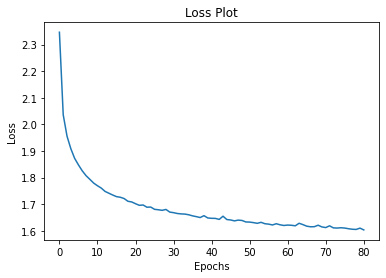

In [2]:
loss_plot = load_loss()
print(len(loss_plot))
plt.plot(loss_plot[:300])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [3]:
units = int(config['config']['units'])
embedding_dim = int(config['config']['embedding_dim'])

vocabulary_size = int(config['config']['vocabulary_size'])


use_glove = bool(config['config']['use_glove'])
glove_dim = int(config['config']['glove_dim'])

In [4]:
val_image_paths, image_path_to_caption_val = import_files(shuffle= False, method = "val")

val_captions = []
img_name_vector_val = []
for image_path in val_image_paths:
  caption_list = image_path_to_caption_val[image_path]
  if len(caption_list)!=5:
    caption_list = caption_list[:5]
  val_captions.extend(caption_list)
  img_name_vector_val.extend([image_path] * len(caption_list))

5000


In [5]:
len(val_captions)

25000

In [6]:
train_image_paths, image_path_to_caption_train = import_files(shuffle= False, method = "train")

train_captions = []
img_name_vector_train = []
for image_path in train_image_paths:
  caption_list = image_path_to_caption_train[image_path]
  if len(caption_list)!=5:
    caption_list = caption_list[:5]
  train_captions.extend(caption_list)
  img_name_vector_train.extend([image_path] * len(caption_list))

118287


In [7]:
len(train_captions)

591435

In [8]:
vocabulary= load_vocab()

In [9]:
word_to_index_val, index_to_word_val, tokenizer_val, cap_vector_val = tokenization(val_captions, max_length, vocabulary_size)

In [10]:
word_to_index_train, index_to_word_train, tokenizer_train, cap_vector_train = tokenization(train_captions, max_length, vocabulary_size)

In [11]:
embeddings_index = {}

if use_glove:
    new_glove_path = f"./dataset/glove.6B/new_glove.6B.{glove_dim}d.pkl"
    tuned_glove = pickle.load(open(new_glove_path, "rb"))
    len(tuned_glove)
    glove_path = f"./dataset/glove.6B/glove.6B.{glove_dim}d.txt"

    with open(glove_path, encoding="utf-8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    embeddings_index.update(tuned_glove)

    print("Found %s word vectors." % len(embeddings_index))

    vocabulary = tokenizer_train.get_vocabulary()
    word_index = dict(zip(vocabulary, range(len(vocabulary))))

    num_tokens = len(vocabulary)
    embedding_dim = 100
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

Found 401581 word vectors.
Converted 23871 words (5771 misses)


In [12]:
encoder = CNN_Encoder(embedding_dim)
if use_glove:
    decoder = RNN_Decoder(embedding_dim, units, num_tokens, embedding_matrix)
else:
    decoder = RNN_Decoder(embedding_dim, units, tokenizer_train.vocabulary_size(), None)
image_features_extract_model = get_feature_extractor()

In [13]:
img_name_val, cap_val = split_data(img_name_vector_val, cap_vector_val ,
                                    image_features_extract_model, 1)

100%|██████████| 157/157 [00:45<00:00,  3.43it/s]


In [14]:
len(cap_vector_val)

25000

In [15]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt.restore(ckpt_manager.latest_checkpoint)

In [16]:
img_name_vector_val[0]

'c:\\Users\\hazem\\Desktop\\collage\\Graduation project\\Unlimited vision app\\dataset\\coco\\val\\val2017\\000000179765.jpg'

In [17]:
img_name_val[0]

'c:\\Users\\hazem\\Desktop\\collage\\Graduation project\\Unlimited vision app\\dataset\\coco\\val\\val2017\\000000327701.jpg'

In [39]:
def makeResultFile(img_name_vector_val, encoder, decoder,
                   image_features_extract_model, word_to_index_train,
                   index_to_word_train, percentage=1):

    result_list = []
    ImgIDs =[]
    samples = (int)(len(img_name_vector_val) * percentage)
    
    for i in range(0, samples, 5):
        id = img_name_vector_val[i].split("val2017\\")[1].split(".")[0]
        cap = predict(img_name_vector_val[i], encoder, decoder, image_features_extract_model,
                      word_to_index_train, index_to_word_train)

        if cap[-1] == "<end>":
            cap.remove("<end>")

        cap = ' '.join(cap)
        imid = int(id.lstrip('0'))
        temp = {"image_id": imid, "caption": cap}

        result_list.append(temp)
        ImgIDs.append(imid)
        
    with open('dataset\coco\\result\\result.json', 'w') as outfile:
        json.dump(result_list, outfile, sort_keys=True)
        

    return result_list, ImgIDs

In [45]:
annotation_file = 'dataset\coco\\val\captions_val2017.json'
results_file = 'dataset\coco\\result\\result.json'

if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        result = json.load(f)
else:
    result_a , ImgIDs = makeResultFile(img_name_vector_val, encoder, decoder,
                    image_features_extract_model, word_to_index_train,
                    index_to_word_train, percentage = 0.2)

In [44]:
# create coco object and coco_result object
coco = COCO(annotation_file)
coco_result = coco.loadRes(results_file)

# create coco_eval object by taking coco and coco_result
coco_eval = COCOEvalCap(coco, coco_result, ImgIDs)

coco_eval.evaluate()

# print output evaluation scores
for metric, score in coco_eval.eval.items():
    print(f'{metric}: {score:.3f}')

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 499, 'reflen': 490, 'guess': [499, 449, 399, 349], 'correct': [228, 73, 16, 3]}
ratio: 1.0183673469366972
Bleu_1: 0.457
Bleu_2: 0.273
Bleu_3: 0.144
Bleu_4: 0.071
computing METEOR score...
METEOR: 0.145
computing Rouge score...
ROUGE_L: 0.349
computing CIDEr score...
CIDEr: 0.372
computing SPICE score...
SPICE: 0.086


In [ ]:
def plot_attention2(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(20, 20))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i], backgroundcolor="white")
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a male tennis player in action on the court <end>
Prediction Caption: a man hitting a tennis racket that a man both hands <end>


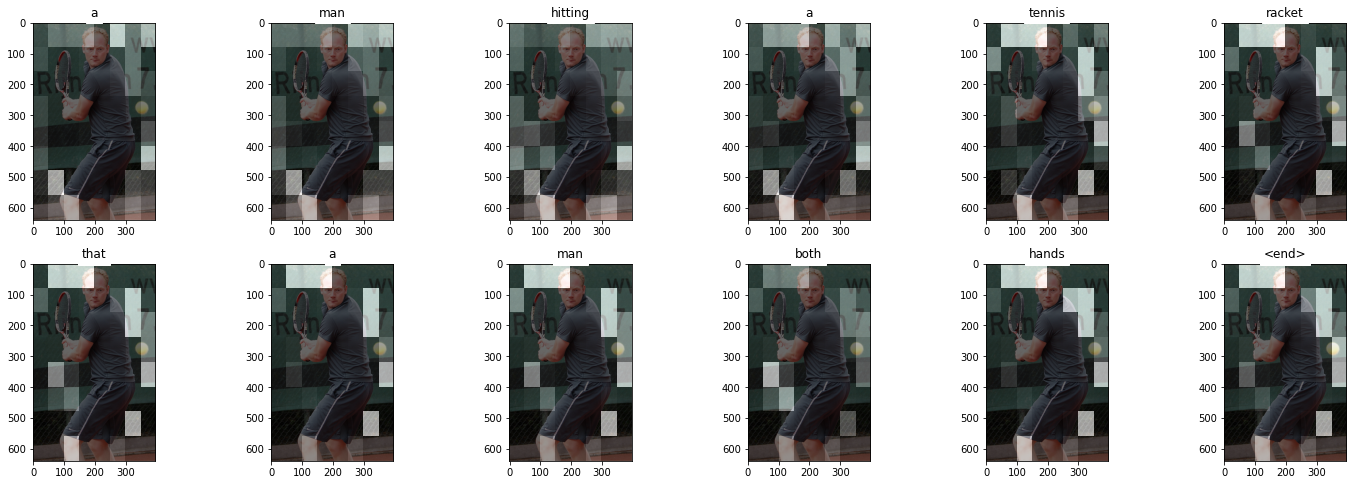

In [31]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word_val(i).numpy())
                         for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, encoder, decoder, image_features_extract_model,
                                    word_to_index_train, index_to_word_train)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)